In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import os
import random
import matplotlib.pyplot as plt

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"


In [2]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Define paths
data_dir = 'data/new_data'
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'validation')
test_path = os.path.join(data_dir, 'test')

In [4]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:
# Load datasets
train_dataset = ImageFolder(root=train_path, transform=train_transform)
val_dataset = ImageFolder(root=val_path, transform=val_transform)
test_dataset = ImageFolder(root=test_path, transform=test_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
# Load pre-trained MobileNetV2 model
model = torchvision.models.mobilenet_v2(pretrained=True)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Modify last layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(train_dataset.classes))

# Send model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# model.load_state_dict(torch.load('model/weight_2.pth'))

<All keys matched successfully>

In [9]:
# Define number of epochs
num_epochs = 60

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()
            
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")



Epoch [1/60], Train Loss: 1.1108, Train Accuracy: 0.6910, Validation Loss: 0.7528, Validation Accuracy: 0.7845
Epoch [2/60], Train Loss: 0.6947, Train Accuracy: 0.8009, Validation Loss: 0.6048, Validation Accuracy: 0.8357
Epoch [3/60], Train Loss: 0.6473, Train Accuracy: 0.8206, Validation Loss: 0.3936, Validation Accuracy: 0.9095
Epoch [4/60], Train Loss: 0.5134, Train Accuracy: 0.8503, Validation Loss: 0.5614, Validation Accuracy: 0.8607
Epoch [5/60], Train Loss: 0.5153, Train Accuracy: 0.8497, Validation Loss: 0.5166, Validation Accuracy: 0.8690
Epoch [6/60], Train Loss: 0.4782, Train Accuracy: 0.8621, Validation Loss: 0.4404, Validation Accuracy: 0.8726
Epoch [7/60], Train Loss: 0.4788, Train Accuracy: 0.8624, Validation Loss: 0.3548, Validation Accuracy: 0.9107
Epoch [8/60], Train Loss: 0.4258, Train Accuracy: 0.8765, Validation Loss: 0.4252, Validation Accuracy: 0.9048
Epoch [9/60], Train Loss: 0.4238, Train Accuracy: 0.8777, Validation Loss: 0.3569, Validation Accuracy: 0.8988
E

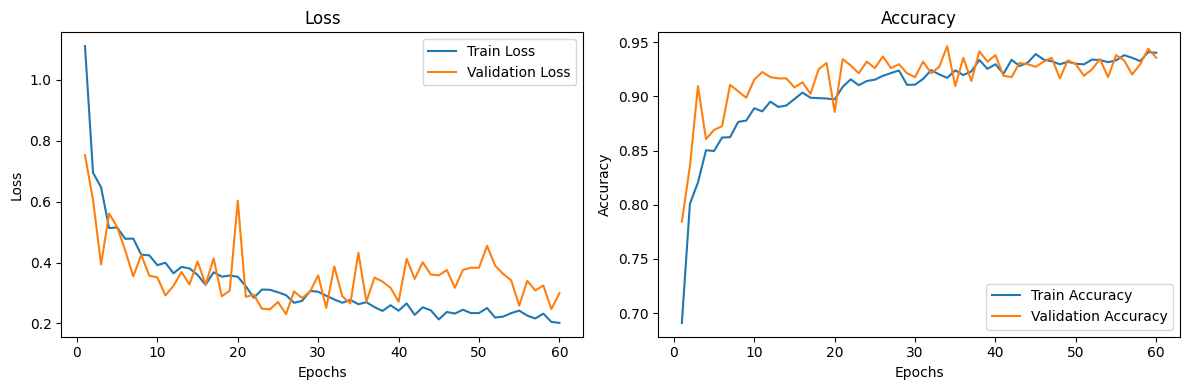

In [10]:
# Plotting training and validation loss and accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [16]:
# Lưu mô hình
torch.save(model, 'model/trained_model.pth')

print("Model saved successfully.")


Model saved successfully.


In [ ]:
# Load the saved weights
model.load_state_dict(torch.load('model/weight_5.pth'))

Predicted label: 13
Confidence score: 0.999599039554596
True label: 13


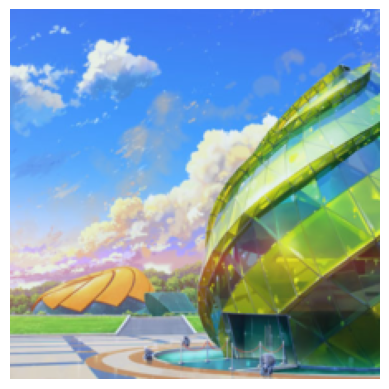

In [24]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_image_index = random.randint(0, len(test_dataset) - 1)
image, true_label = test_dataset[random_image_index]
image = image.unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model(image)
    predicted_probabilities = F.softmax(output, dim=1)
    confidence_score, predicted_label = torch.max(predicted_probabilities, 1)
    predicted_label = predicted_label.item()
    confidence_score = confidence_score.item()

# Get the label names
labels = [label for label in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, label))]
predicted_label_name = labels[predicted_label]

print("Predicted label:", predicted_label_name)
print("Confidence score:", confidence_score)
print("True label:", test_dataset.classes[true_label])

# Display the image
image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

plt.imshow(image_np)
plt.axis('off')
plt.show()
